# 雷达数据

## 雷达数据的绘制和上传redis




/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/cinrad/calc.py:110: RuntimeWarning: All-NaN axis encountered
  cr = np.nanmax(r_data, axis=0)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


CPU times: user 16.2 s, sys: 1.05 s, total: 17.3 s
Wall time: 4.97 s


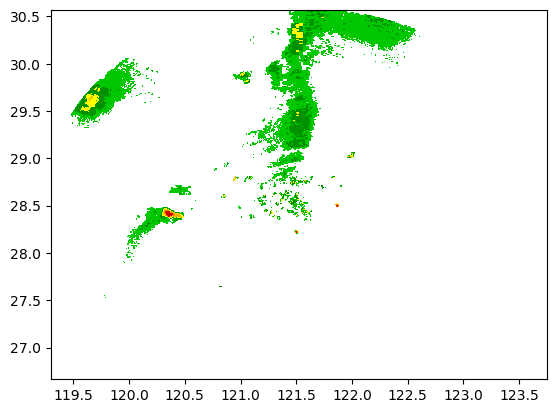

In [1]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)
    
class radar_data:
    def __init__(self):
        self.rs = redis.Redis(host='127.0.0.1', port=6379)
    def to_redis(self,imd):
        if self.rs.get("radar"):
            data = pickle.loads(self.rs.get("radar"))  
            radar_len = len(data['imglist'])
            if radar_len>10:
                data['imglist'] = data['imglist'][-9:]
                data['imglist'].append(imd)
            else:
                data['imglist'].append(imd)
        else:
            imglist = [imd]
            data = {
                "imglist":imglist
            }
        self.rs.set("radar", pickle.dumps(data))       
    def plot_data(self):
#         path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
#         f = cinrad.io.CinradReader(path+'Z_RADR_I_Z9576_20150809120400_O_DOR_SA_CAP.bin.bz2')
        path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
        f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
        tilt_number = 0
        data_radius = 230
        data_dtype = 'REF' # stands for reflectivity
        # 数据加载核心
        ra = f.get_data(tilt_number, data_radius, data_dtype)
        rl = list(f.iter_tilt(230, 'REF'))
        cr = cinrad.calc.quick_cr(rl)
        data = cr.CR
        output = data.interp(latitude=np.linspace(min(data.latitude).data, max(data.latitude).data, 500),longitude = np.linspace(min(data.longitude).data, max(data.longitude).data, 500),method="nearest")
        m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
        ## 颜色 ------
        colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
        levels1 = [20,25,30,35,40,45,50,55,60,65,70,75]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
        contour = plt.contourf(output.longitude, output.latitude, output,cmap=cmaps,levels = levels1)
#         plt.axis('off') 
        geojson = geojsoncontour.contourf_to_geojson(
            contourf=contour,
            ndigits=3,
            unit='dbz'
        )
        self.to_redis(geojson)
        return data
    def get_radar(self):
        data = pickle.loads(self.rs.get("radar"))
        return data

worker = radar_data()
data = worker.plot_data()
#data = worker.get_radar()

# 雷达剖面测试

In [11]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour

lat_point = [28.2,29.40]
lon_point = [121.25,121.45]
path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
rl = [f.get_data(i, 230, 'REF') for i in f.angleindex_r]
vcs = cinrad.calc.VCS(rl)
# pass geographic coordinates (longitude, latitude)

#fig = Section(sec)

CPU times: user 31.3 s, sys: 86.4 ms, total: 31.4 s
Wall time: 3.17 s


In [12]:
%%time
sec = vcs.get_section(start_cart=(121.25, 28.2), end_cart=(121.45, 29.40)) 

CPU times: user 231 ms, sys: 6.23 ms, total: 237 ms
Wall time: 236 ms


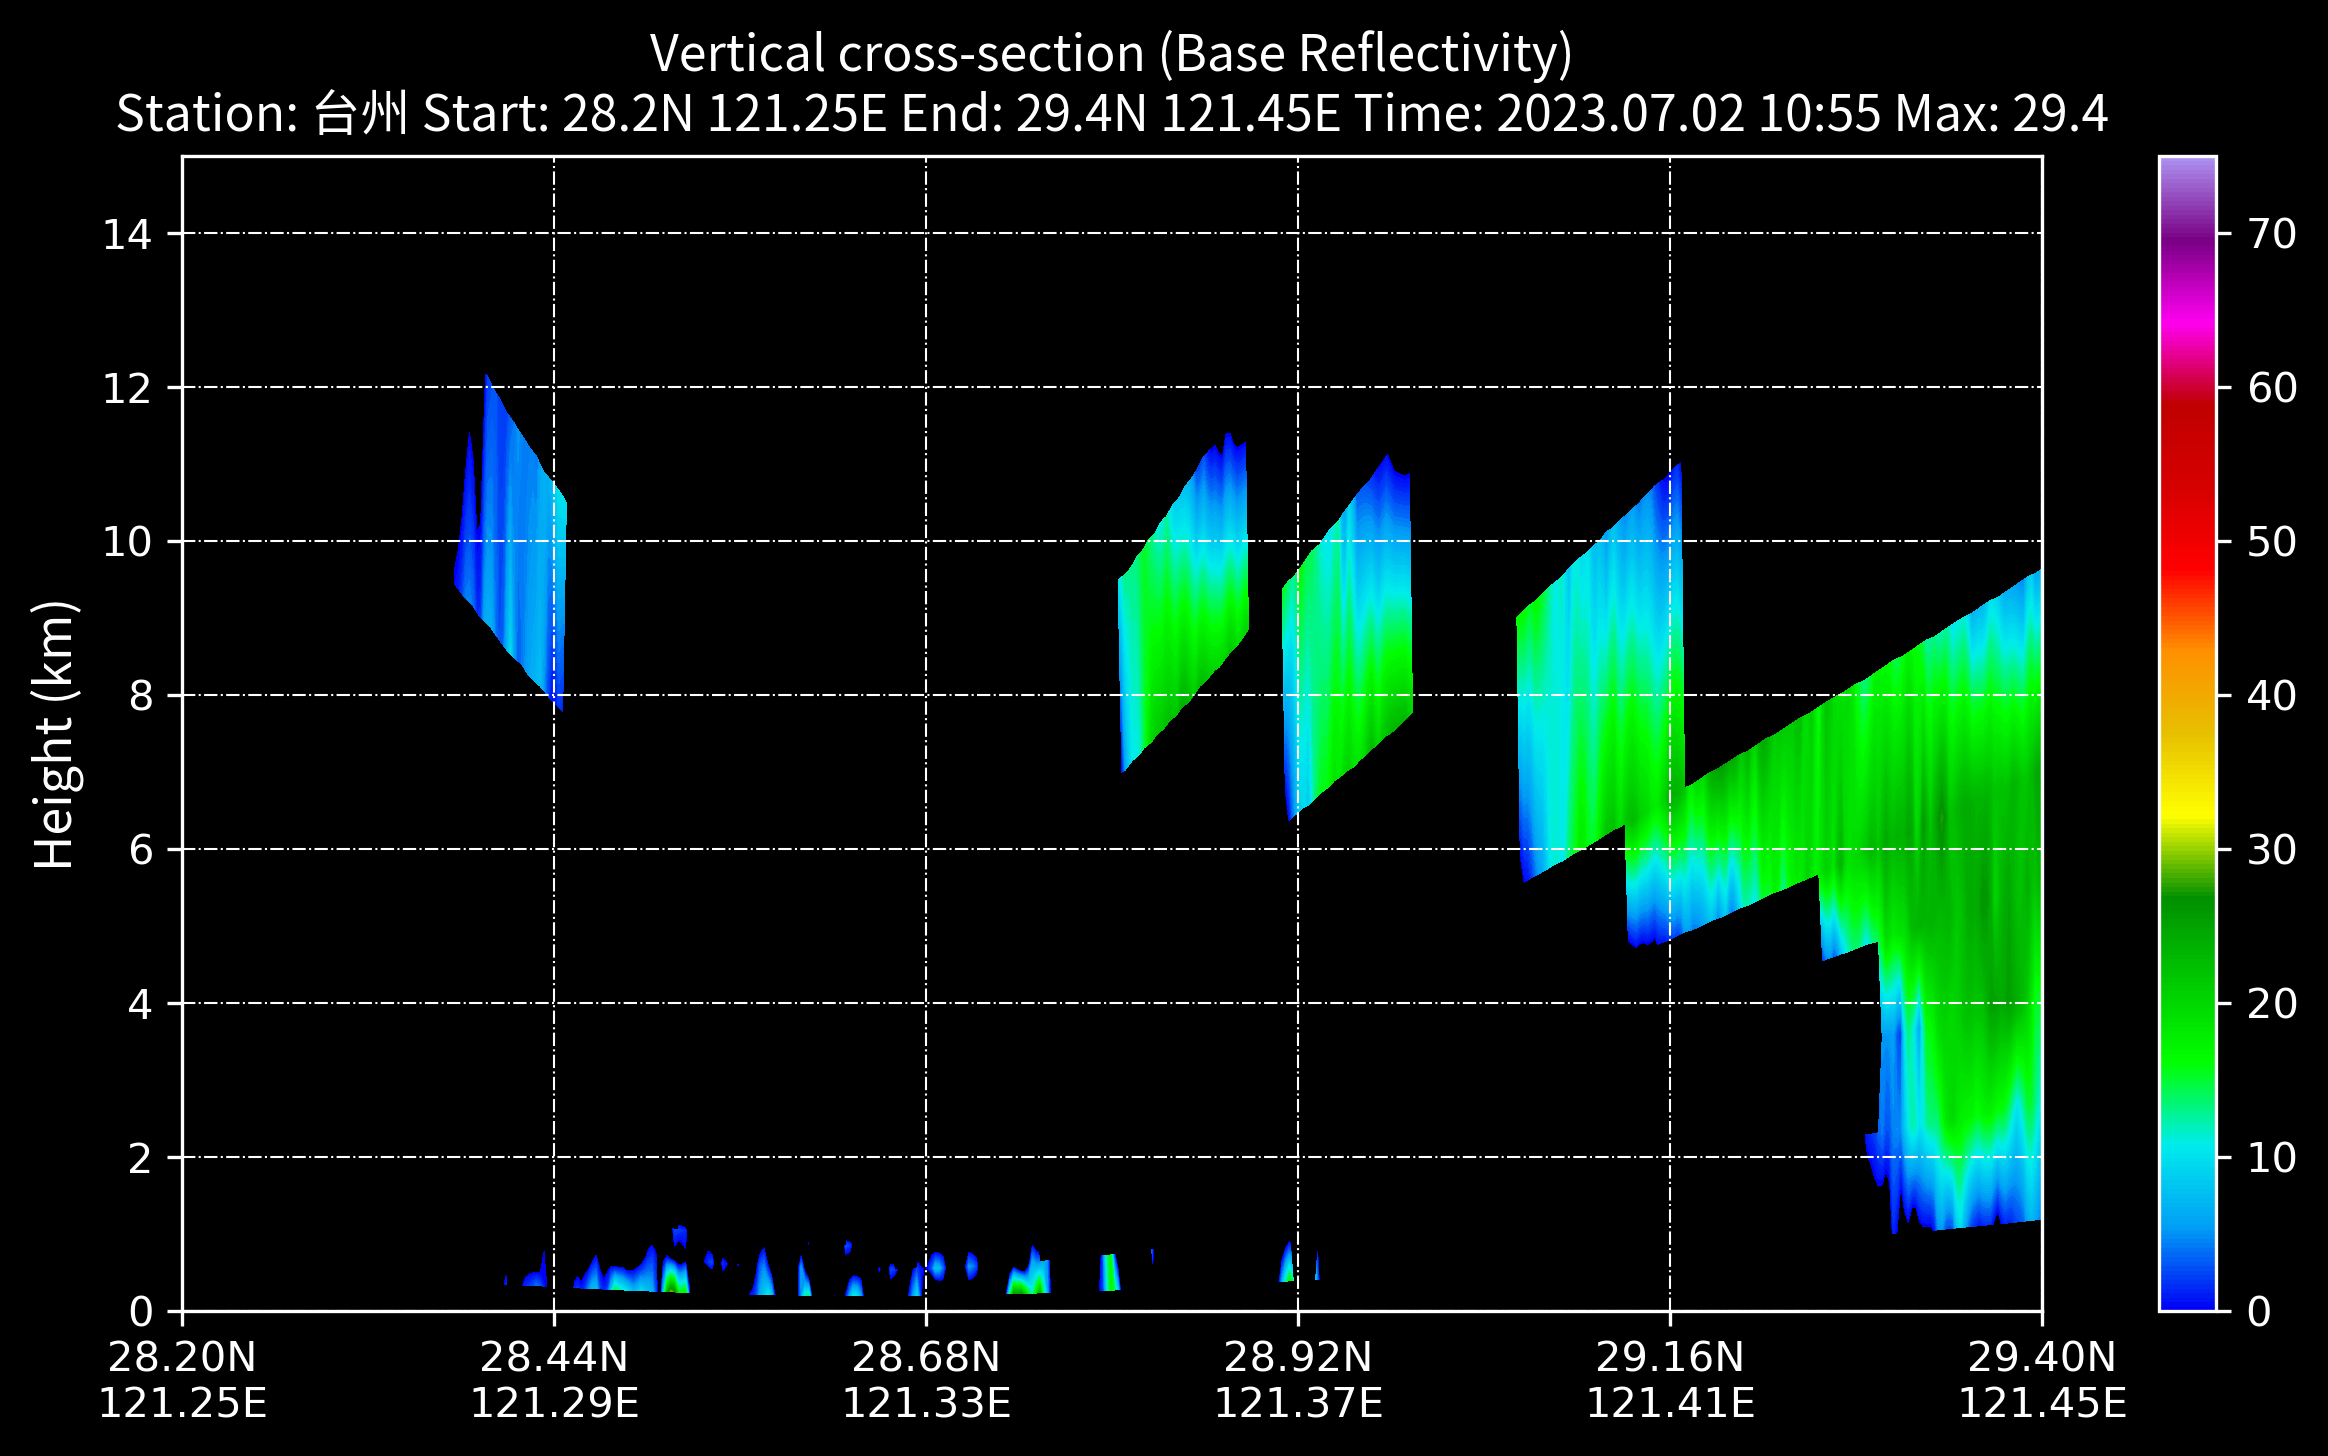

In [13]:
from cinrad.visualize import Section
fig = Section(sec)

In [17]:
sec

<xarray.Dataset>
Dimensions:  (distance: 9, tilt: 500)
Dimensions without coordinates: distance, tilt
Data variables:
    REF      (distance, tilt) float64 -0.4139 -1.869 -3.543 ... nan nan nan
    y_cor    (distance, tilt) float64 0.6249 0.6215 0.617 ... 31.19 31.29 31.36
    x_cor    (distance, tilt) float64 0.0 0.002004 0.004008 ... 0.996 0.998 1.0
Attributes:
    scan_time:       2023-07-02 10:55:50
    site_code:       Z9576
    site_name:       台州
    site_longitude:  121.522224
    site_latitude:   28.618055
    nyquist_vel:     8.695016
    task:            VCP21D
    start_lon:       121.25
    start_lat:       28.2
    end_lon:         121.45
    end_lat:         29.4

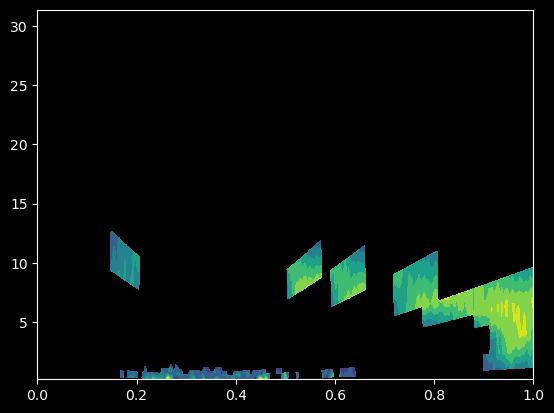

In [23]:
sec_d = sec.REF
xcor = sec.x_cor
ycor = sec.y_cor
plt.contourf(xcor, ycor, sec_d)

In [21]:
ycor.shape

(9, 500)